In [34]:
import numpy
import matplotlib.pyplot as plt
import cv2
import os
import random
import numpy as np

In [35]:
input_img = cv2.imread('frame5131.jpg')

In [36]:
def calculate_snr(image):
    
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    mean_intensity = np.mean(image)
    variance = np.var(image)
    snr = 10 * np.log10(mean_intensity**2 / variance)

    return snr

In [37]:
calculate_snr(input_img)

16.387343841346425

50

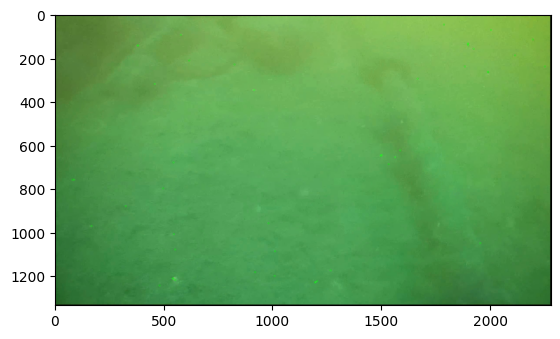

In [38]:
def calculate_features(image):

    fast12 = cv2.FastFeatureDetector_create(nonmaxSuppression = True)

    keypoints = fast12.detect(image, None)

    # Draw the detected keypoints on the image
    output_image = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Count the number of detected features
    num_features = len(keypoints)
    # print(f"Number of FAST-12 features detected: {num_features}")

    # Display the image with keypoints
    plt.imshow(output_image)
    return num_features

calculate_features(input_img)



In [39]:
def CLAHE(image):

    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    clahe_image = clahe.apply(gray_image)

    if len(image.shape) == 3:
        clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2BGR)

    return clahe_image

In [40]:
def white_balance(image):
   
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    l, a, b = cv2.split(lab_image)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    balanced_lab_image = cv2.merge((cl, a, b))

    balanced_image = cv2.cvtColor(balanced_lab_image, cv2.COLOR_LAB2BGR)

    return balanced_image



In [41]:
def Contrast_Up(image):
    
    contrasted_image = cv2.convertScaleAbs(image, alpha=4.0, beta=0)
    return contrasted_image

def Contrast_Down(image):
    
    contrasted_image = cv2.convertScaleAbs(image, alpha=0.2, beta=0)
    return contrasted_image

def Brightness_Up(image):
    
    brightened_image = cv2.convertScaleAbs(image, alpha=1.0, beta=150)
    return brightened_image

def Brightness_Down(image):
    
    darkened_image = cv2.convertScaleAbs(image, alpha=1.0, beta=10)
    return darkened_image

In [42]:
class Agent:
    def __init__(self,image):
        self.actions = ['WB','C_Up','C_Down','Bs_Up','B_Down','CLAHE']
        self.states = ['F0','F1','F2','F3','F4','F5']
        self.rewards = [-5,-1,1,2,3,4,5]
        self.target_reached = 0
        # self.step_limit = 6
        self.memory = []
        self.image = image
        self.steps = 0
        self.cumulative_reward = 0
        self.learning_rate = 0.1
        self.discount_factor = 0.9
        self.exploration_prob = 0.6
        self.num_episodes = 10

        self.Q = np.zeros((len(self.states), len(self.actions)))

    def check_state(self,image):
        num_of_features = calculate_features(image)
        if num_of_features < 0:
            return 'F0'
        elif num_of_features >= 0 and num_of_features < 100 :
            return 'F1'
        elif num_of_features <=200 and num_of_features > 100:
            return 'F2'
        elif num_of_features <=300 and num_of_features > 200:
            return 'F3'
        elif num_of_features <=400 and num_of_features > 300:
            return 'F4'
        elif  num_of_features > 400:
            return 'F5'
    
    def get_feature_difference(self,ft1,ft2):
        i1 = self.states.index(ft1)
        i2 = self.states.index(ft2)
        return (i2-i1) * 100

    def update_reward(self,st1,st2):
        print(st2,st1)
        feature_difference = self.get_feature_difference(st2,st1)
        
        if feature_difference <0:
            return -5
        elif feature_difference == 0:
            return -1
        elif feature_difference <= 100 and feature_difference > 0:
            return 1
        elif feature_difference <= 200 and feature_difference > 100:
            return 2
        elif feature_difference <= 300 and feature_difference > 200:
            return 3
        elif feature_difference <= 400 and feature_difference > 300:
            return 4
        elif feature_difference > 400 :
            return 5
        
    def update_memory(self,a,s,sd,r):
        self.memory.append([a,s,sd,r])
    
    def perform_action(self,ind,img_inp):
        self.steps += 1
        if ind == 0:
            denoised = white_balance(img_inp)
            return denoised
        elif ind == 1:
            denoised = Contrast_Up(img_inp)
            return denoised
        
        elif ind == 2:
            denoised = Contrast_Down(img_inp)
            return denoised
        elif ind == 3:
            denoised = Brightness_Up(img_inp)
            return denoised
        elif ind == 4:
            denoised = Brightness_Down(img_inp)
            return denoised
        elif ind == 5:
            denoised = CLAHE(self.image)
            return denoised
    
    def select_action(self,state):
        if np.random.rand() < self.exploration_prob:
            return np.random.choice(len(self.actions))  # Exploration: Choose a random action
        else:
            return np.argmax(self.Q[state, :])  # Exploitation: Choose the action with the highest Q-value
    
    def next_state(self,image ,action):
        next_img = self.perform_action(action,image)

        return self.check_state(next_img)
        
    def Q_train(self):
    
        curr_image = self.image

        for episode in range(self.num_episodes):
            init_state = self.check_state(self.image)
            state = self.states.index(self.check_state(self.image))

            for tries in range(100):
                curr_state = self.check_state(curr_image)
                action = self.select_action(state)
                # print("Action : ",action)
                
                # Perform the selected action and observe the next state and reward
                if action == 0:
                    next_state = self.next_state(curr_image,0)
                    print(curr_state,next_state)
                    reward = self.update_reward(next_state,curr_state)
                    self.update_memory(self.actions[action],curr_state,next_state,reward)
                    self.cumulative_reward += reward
                elif action == 1:
                    next_state = self.next_state(curr_image,1)
                    print(curr_state,next_state)
                    reward = self.update_reward(next_state,curr_state)
                    self.update_memory(self.actions[action],curr_state,next_state,reward)
                    self.cumulative_reward += reward
                elif action == 2:
                    next_state = self.next_state(curr_image,2)
                    print(curr_state,next_state)
                    reward = self.update_reward(next_state,curr_state)
                    self.update_memory(self.actions[action],curr_state,next_state,reward)
                    self.cumulative_reward += reward
                elif action == 3:
                    next_state = self.next_state(curr_image,3) 
                    print(curr_state,next_state)
                    reward = self.update_reward(next_state,curr_state)
                    self.update_memory(self.actions[action],curr_state,next_state,reward)
                    self.cumulative_reward += reward
                elif action == 4:
                    next_state = self.next_state(curr_image,4)
                    print(curr_state,next_state)
                    reward = self.update_reward(next_state,curr_state)
                    self.update_memory(self.actions[action],curr_state,next_state,reward)
                    self.cumulative_reward += reward
                elif action == 5:
                    next_state = self.next_state(curr_image,5)
                    print(curr_state,next_state)
                    reward = self.update_reward(next_state,curr_state)
                    self.update_memory(self.actions[action],curr_state,next_state,reward)
                    self.cumulative_reward += reward
                
                # print(self.memory)
                print('cumulative_reward = ',self.cumulative_reward)
                    
        
                # Update the Q-value using the Q-learning update rule 
                self.Q[self.states.index(curr_state), action] = self.Q[self.states.index(curr_state), action] + self.learning_rate * (reward + self.discount_factor * np.max(self.Q[self.states.index(next_state), :]) - self.Q[self.states.index(curr_state), action])
                
                state = self.states.index(next_state)  # Move to the next state
                # print("After action: ",curr_state,next_state)
                # print("Feature_Diff: ",self.get_feature_difference(curr_state,init_state))
                #terminating condition
                if self.get_feature_difference(curr_state,init_state) > 200 :
                    plt.imshow(curr_image)
                    name = "A.jpg"
                    cv2.imwrite('images\qlr/' + name )
                    print("Target Reached")
                    break
                if tries == 100:
                    print("Episode Force Stopped")

        # while self.target_reached == 0 and self.steps < self.step_limit:
        #     print('Training')
        #     init_features = len(fast12.detect(image, None))
        #     select_action = random.randint(0,5)
        #     denoised_img = self.perform_action(select_action,image)
        #     image = denoised_img
        #     temp_keypoints = fast12.detect(denoised_img, None)
        #     num_features = len(temp_keypoints)
        #     feature_diff = num_features - init_features
        #     print(feature_diff)
        #     self.update_memory(self.actions[select_action],self.check_state(init_features),self.check_state(num_features),self.update_reward)
        #     self.cumulative_reward += self.update_reward(feature_diff)
        #     print(self.cumulative_reward)
        #     if feature_diff > 100:
        #         print('Target_Reached',training_steps = self.steps,increase_in_features = feature_diff)
        #         self.target_reached == 1

F1 F5
F1 F5
cumulative_reward =  4
F1 F5
F1 F5
cumulative_reward =  8
F1 F5
F1 F5
cumulative_reward =  12
F1 F1
F1 F1
cumulative_reward =  11
F1 F5
F1 F5
cumulative_reward =  15
F1 F5
F1 F5
cumulative_reward =  19
F1 F5
F1 F5
cumulative_reward =  23
F1 F5
F1 F5
cumulative_reward =  27
F1 F5
F1 F5
cumulative_reward =  31
F1 F5
F1 F5
cumulative_reward =  35
F1 F5
F1 F5
cumulative_reward =  39
F1 F5
F1 F5
cumulative_reward =  43
F1 F5
F1 F5
cumulative_reward =  47
F1 F1
F1 F1
cumulative_reward =  46
F1 F1
F1 F1
cumulative_reward =  45
F1 F5
F1 F5
cumulative_reward =  49
F1 F5
F1 F5
cumulative_reward =  53
F1 F5
F1 F5
cumulative_reward =  57
F1 F1
F1 F1
cumulative_reward =  56
F1 F5
F1 F5
cumulative_reward =  60
F1 F1
F1 F1
cumulative_reward =  59
F1 F1
F1 F1
cumulative_reward =  58
F1 F5
F1 F5
cumulative_reward =  62
F1 F5
F1 F5
cumulative_reward =  66
F1 F5
F1 F5
cumulative_reward =  70
F1 F5
F1 F5
cumulative_reward =  74
F1 F5
F1 F5
cumulative_reward =  78
F1 F5
F1 F5
cumulative_reward 

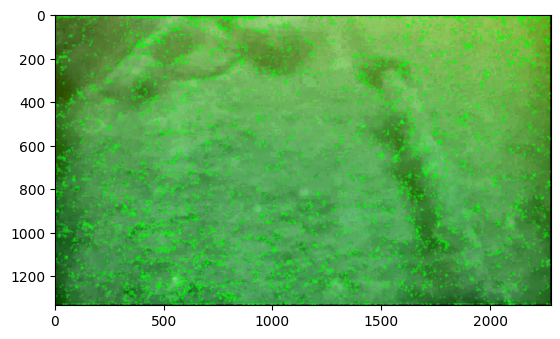

In [43]:
A1 = Agent(input_img)

A1.Q_train()

In [44]:
rewards = []
for i in A1.memory:
    rewards.append(i[-1])

In [45]:
def Cumulative_sum(lists):   
    cum_list = []   
    length = len(lists)   
    cum_list = [sum(lists[0:x:1]) for x in range(0, length+1)]   
    return cum_list[1:]  
   
print (Cumulative_sum(rewards)) 

[4, 8, 12, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 46, 45, 49, 53, 57, 56, 60, 59, 58, 62, 66, 70, 74, 78, 82, 81, 80, 84, 88, 92, 96, 100, 99, 103, 102, 106, 105, 109, 113, 117, 116, 120, 124, 128, 132, 136, 140, 139, 138, 137, 141, 145, 144, 148, 152, 151, 155, 154, 158, 162, 166, 165, 169, 168, 172, 171, 175, 174, 178, 182, 186, 185, 189, 193, 192, 196, 200, 204, 203, 207, 211, 215, 214, 218, 222, 226, 225, 229, 233, 237, 241, 245, 249, 253, 257, 261, 265, 264, 263, 262, 261, 265, 264, 268, 272, 276, 275, 279, 283, 287, 286, 285, 289, 288, 292, 291, 295, 299, 303, 302, 301, 305, 309, 313, 317, 321, 325, 329, 328, 327, 331, 335, 334, 333, 337, 341, 340, 344, 348, 352, 351, 355, 359, 358, 362, 366, 370, 374, 373, 372, 376, 375, 379, 378, 377, 376, 380, 384, 383, 382, 381, 385, 389, 393, 397, 396, 400, 404, 408, 407, 411, 410, 414, 413, 417, 421, 425, 429, 433, 437, 441, 445, 444, 448, 447, 446, 445, 449, 448, 452, 451, 455, 454, 458, 462, 466, 470, 469, 473, 477, 481, 480, 484, 488, 4

In [46]:
# import numpy as np


# # Define Q-table to store Q-values for each state-action pair
# num_states = 5
# num_actions = 4  # Up, Down, Left, Right
# Q = np.zeros((num_states, num_actions))

# # Define parameters for the Q-learning algorithm
# learning_rate = 0.1
# discount_factor = 0.9
# exploration_prob = 0.2
# num_episodes = 1000

# # Define a function to convert a state from the environment to an index
# # def state_to_index(state):
# #     return np.ravel_multi_index(np.where(env == state), env.shape)

# # Define a function to select an action using epsilon-greedy policy
# def select_action(state):
#     if np.random.rand() < exploration_prob:
#         return np.random.choice(num_actions)  # Exploration: Choose a random action
#     else:
#         return np.argmax(Q[state, :])  # Exploitation: Choose the action with the highest Q-value

# # Q-learning training loop
# for episode in range(num_episodes):
#     state = self.states.index(check_state(self.image))  # Start from the initial state 'S'
    
#     while True:
#         action = select_action(state)
        
#         # Perform the selected action and observe the next state and reward
#         if action == 0:  # Up
#             next_state = state_to_index(env[np.where(env == 'S')])  # Stay at 'S'
#             reward = 0
#         elif action == 1:  # Down
#             next_state = state_to_index(env[np.where(env == 'H')])  # Hit an obstacle, stay there
#             reward = 0
#         elif action == 2:  # Left
#             next_state = state_to_index(env[np.where(env == 'S')])  # Stay at 'S'
#             reward = 0
#         elif action == 3:  # Right
#             next_state = state_to_index(env[np.where(env == ' ')] or env[np.where(env == 'G')])  # Move to an empty cell or the goal
#             reward = 1 if env[np.where(env == 'G')] else 0  # +1 if reached the goal, else 0
        
#         # Update the Q-value using the Q-learning update rule
#         Q[state, action] = Q[state, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state, :]) - Q[state, action])
        
#         state = next_state  # Move to the next state
        
#         if env[np.where(env == 'G')]:  # Reached the goal
#             break

# # Now, the Q-table contains learned Q-values, and the agent can use them to make decisions
# # You can use the Q-table to find the optimal policy or evaluate the agent's performance
